### Preliminary Necessities

In [1]:
# Import necessary modules
import mne
import numpy as np
import pandas as pd
import os
from mne.externals.pymatreader import read_mat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata

In [2]:
# Set parameters
DATA_DIR = '../data/from_osf'
EEG_DIR = 'EEG'
EXP = 1
SUBJ = 1
ALPHA_BAND = (8, 12)
N_BLOCKS = 3
N_BLOCK_ITERS = 10
IEM_N_CHANNELS = 8
IEM_FEAT_SPACE_EDGES = (0, 359)
IEM_BASIS_FUNC = lambda theta: np.sin(0.5 * np.radians(theta)) ** 7 
FEATURE_NAME = 'Spatial Location'


### Load Data from MAT Files

In [3]:
# Load EEG data for one subject
eeg_mat_fname = os.path.join(DATA_DIR, 'exp{}'.format(
    EXP), EEG_DIR, '{}_EEG.mat'.format(SUBJ))
eeg_data = read_mat(eeg_mat_fname)['eeg']
info = mne.create_info(
    eeg_data['chanLabels'], eeg_data['sampRate'], ch_types='eeg')
epochs = mne.EpochsArray(
    eeg_data['data'], info, tmin=eeg_data['preTime'] / 1000).drop(
        eeg_data['arf']['artIndCleaned'].astype(bool))
n_channels, n_timepts = epochs.get_data().shape[-2:]
assert epochs.times[-1] == eeg_data['postTime'] / 1000

# Load behavioral data for one subject
beh_mat_fname = os.path.join(DATA_DIR, 'exp{}'.format(
    EXP), 'Data', '{}_MixModel_wBias.mat'.format(SUBJ))
beh_data = read_mat(beh_mat_fname)['beh']['trial']
beh_data_cleaned = {k: val[~eeg_data['arf']['artIndCleaned'].astype(
    bool)] for k, val in beh_data.items()}
pos_bins = beh_data_cleaned['posBin']

Not setting metadata
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Dropped 151 epochs: 2, 42, 71, 78, 83, 102, 108, 111, 115, 124, 129, 134, 154, 160, 164, 175, 176, 184, 205, 207, 210, 211, 217, 218, 221, 222, 223, 224, 225, 227, 244, 246, 248, 253, 255, 302, 306, 309, 311, 317, 333, 335, 336, 338, 374, 408, 457, 469, 471, 480, 481, 485, 486, 489, 503, 504, 506, 510, 544, 545, 548, 550, 551, 557, 564, 569, 586, 590, 591, 592, 596, 614, 623, 641, 659, 660, 667, 674, 675, 677, 690, 693, 694, 695, 697, 741, 742, 749, 750, 751, 754, 757, 758, 759, 767, 789, 790, 799, 802, 803, 809, 810, 813, 814, 820, 821, 823, 824, 828, 829, 834, 841, 843, 845, 851, 853, 854, 856, 857, 858, 861, 864, 865, 866, 870, 871, 872, 873, 874, 877, 878, 879, 881, 886, 887, 890, 911, 912, 915, 916, 920, 925, 926, 930, 934, 935, 937, 938, 948, 952, 957


### EEG Preprocessing

In [4]:
# Band-pass filter in alpha band
alpha_band = epochs.copy().filter(*ALPHA_BAND)

# Apply Hilbert transform to get analytic signal
analytic_sig = alpha_band.copy().apply_hilbert()

# Get total power from analytic signal
total_power = analytic_sig.copy().apply_function(np.abs).apply_function(
    np.square)

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 sec)



In [5]:
# Run block iteration multiple times
block_iters = []
for _ in range(N_BLOCK_ITERS):
    # Seperate into blocks
    blocks = [np.array([]) for _ in range(N_BLOCKS)]
    for val in set(pos_bins):
        # Find indices with particular values and randomly permute these indices
        rand_inds = np.random.permutation(
            np.where(beh_data_cleaned['posBin'] == val)[0])

        # Split these indices into blocks
        blocks_val = np.array_split(rand_inds, N_BLOCKS)

        # Add blocks of particular value to big blocks structure
        blocks = sorted(blocks, key=len)
        blocks = [np.concatenate((block, block_val)) for block, block_val in zip(
            blocks, blocks_val)]

    # Order blocks by length (max difference between any two blocks' length should 
    # be 1)
    blocks = sorted(blocks, key=len)

    # Add block assignments to block iterations list
    block_iters.append(blocks)

In [6]:
n_trials_per_bin = np.bincount(pos_bins - 1).min() // N_BLOCKS * N_BLOCKS
idx_split_by_vals = np.split(np.argsort(pos_bins), np.where(np.diff(sorted(
        pos_bins)))[0]+1)

total_power_arrs = []
for blocks in block_iters:
    # Calculate total power for blocks of trials
    total_power_arr = np.zeros((len(set(
        pos_bins)) * N_BLOCKS, n_channels, n_timepts))
    for i, val_split in enumerate(idx_split_by_vals):
        idx = np.random.permutation(val_split)[:n_trials_per_bin]
        block_avg = np.real(np.mean(total_power.get_data()[idx, :, :].reshape(
            -1, N_BLOCKS, n_channels, n_timepts), axis=0))
        total_power_arr[i*N_BLOCKS:(i+1)*N_BLOCKS, :, :] = block_avg

    # Rearrange axes of data to work for IEM pipeline
    total_power_arr = np.moveaxis(total_power_arr, 0, 1)

    # Add total power array to list
    total_power_arrs.append(total_power_arr)

In [7]:
class IEM():
    def __init__(self, n_channels=IEM_N_CHANNELS, basis_func=IEM_BASIS_FUNC, 
            feat_space_edges=IEM_FEAT_SPACE_EDGES, feature_name=FEATURE_NAME):
        self.n_channels = n_channels
        self.basis_func = basis_func
        self.feat_space_edges = feat_space_edges
        self.feature_name = feature_name

        self.feat_space_range = (np.diff(self.feat_space_edges)[0] + 1).astype(
            int)
        self.theta = np.linspace(*self.feat_space_edges, self.feat_space_range)
        self.channel_centers = np.linspace(
            self.feat_space_edges[0], self.feat_space_edges[-1] + 1, 
            self.n_channels + 1)[:-1].astype(int)
        self.basis_set = np.array([np.roll(self.basis_func(
            self.theta), channel_center - len(
                self.theta) // 2) for channel_center in self.channel_centers])
        
        self.design_matrix = None
        self.weights = None
        return
    
    def _gen_design_matrix(self, labels):
        self.design_matrix = self.basis_set @ np.eye(len(self.theta))[labels].T
        return

    def fit_iem(self, train_data):
        inv = np.linalg.inv(self.design_matrix @ self.design_matrix.T)
        self.weights = train_data @ self.design_matrix.T @ inv
        return

    def train_model(self, train_data, train_labels):
        self._gen_design_matrix(train_labels)
        self.fit_iem(train_data)
        return

    def estimate_crf(self, test_data, test_labels):
        inv = np.linalg.inv(self.weights.T @ self.weights)
        self.estimated_crfs = inv @ self.weights.T @ test_data
        test_labels_idx = rankdata(test_labels, method='dense') - 1
        self.estimated_ctfs = np.array([np.roll(
            crf, -label_idx) for crf, label_idx in zip(
                self.estimated_crfs.T, test_labels_idx)]).T
        self.channel_offsets = self.basis_set.T @ self.estimated_ctfs
        self.mean_channel_offset = np.roll(np.mean(
            self.channel_offsets, axis=1), self.feat_space_range // 2)
        return
        
    def plot_channel_basis_funcs(self):
        df = pd.DataFrame({
            'Angular Location (°)': np.tile(self.theta, self.n_channels), 
            'Peak Response (°)': np.repeat(self.channel_centers, len(
                self.theta)),
            'Channel Activation': self.basis_set.flatten()})
        g = sns.lineplot(
            x='Angular Location (°)', y='Channel Activation', 
            hue='Peak Response (°)', data=df)
        g.legend(labels=self.channel_centers, bbox_to_anchor=(
            1.05, 1), title='Peak Response (°)')

In [8]:
channel_centers = np.linspace(
    IEM_FEAT_SPACE_EDGES[0], IEM_FEAT_SPACE_EDGES[-1] + 1, 
    IEM_N_CHANNELS + 1)[:-1].astype(int)

def estimate_crf_one_block(train_data, train_labels, test_data, test_labels):
    iem = IEM()
    iem.train_model(train_data, train_labels)
    iem.estimate_crf(test_data, test_labels)
    return iem.mean_channel_offset

def estimate_crf_one_tp(total_power_arr_one_tp):
    block_crfs = []
    for test_block in range(N_BLOCKS):
        train_data = total_power_arr_one_tp[:, np.mod(np.arange(
            total_power_arr.shape[1]), N_BLOCKS) != test_block]
        train_labels = np.tile(channel_centers, N_BLOCKS - 1)
        test_data = total_power_arr_one_tp[:, np.mod(np.arange(
            total_power_arr.shape[1]), N_BLOCKS) == test_block]
        test_labels = channel_centers
        block_crfs.append(estimate_crf_one_block(
            train_data, train_labels, test_data, test_labels))
    return np.mean(np.stack(block_crfs), axis=0)

crfs_by_tp = []
for total_power_arr in total_power_arrs:
    crfs_by_tp_each_iter = []
    for total_power_arr_one_tp in np.rollaxis(total_power_arr, -1):
        crfs_by_tp_each_iter.append(estimate_crf_one_tp(total_power_arr_one_tp))
    crfs_by_tp.append(np.stack(crfs_by_tp_each_iter))

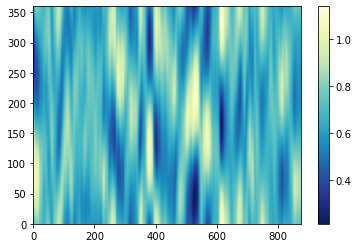

In [9]:
plt.figure()
plt.pcolormesh(np.mean(crfs_by_tp, axis=0).T, cmap='YlGnBu_r')
plt.colorbar()